# Homework 3

David Marcell Prifer (`prifer@kth.se`)

AI declaration: No direct use of LLMs. **AI usage Level 2** is inherent due to the built-in AI assistant of PyCharm that assists with syntax, debugging, code generation, etc. Code inspirations were taken from the coursebook.


## Load and inspect data

In [1]:
from keras.src.metrics.accuracy_metrics import accuracy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysindy as ps


folder = r'C:\Users\prife\OneDrive - KTH\KTH\01 Courses\Data-driven Methods\HW3' + "\\"
data = loadmat(folder + "DataHw3Q1.mat")

X = np.array(data['x'])
t = np.array(data['t'])
t = t[:, 0]  # (1001,1) --> (1001,)

pd.DataFrame(X).describe()

,0,1
count,1001.000000,1001.000000
mean,0.574825,0.679735
std,0.913062,0.580926
min,-1.308773,-0.542237
25%,0.079300,0.280303
50%,0.713524,0.896526
75%,1.297615,1.171106
max,1.917320,1.267421


(1001, 2)
(1001,)


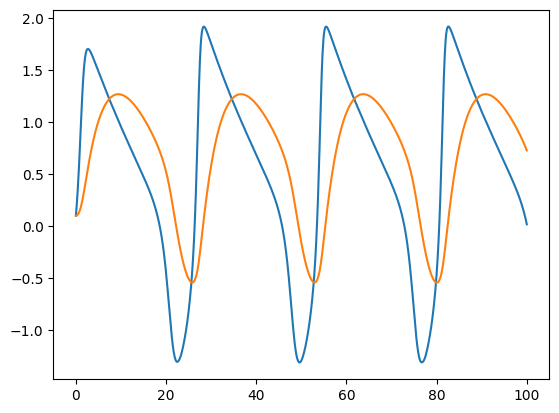

In [2]:
print(X.shape)
print(t.shape)

plt.plot(t,X)
plt.show()

## Problem 1: SINDy

$$
\mathbf{X} =
\begin{bmatrix}
x_1(t_1) & x_2(t_1) \\
x_1(t_2) & x_2(t_2) \\
\vdots & \vdots  \\
x_1(t_{1001}) & x_2(t_{1001})
\end{bmatrix}
\downarrow\!\!\text{time}
$$

The ODEs that describe the system are

$$
\dot{x}_1 = \sum_{j,k} c_{j,k} \, x_1^j \, x_2^k,
$$

and

$$
\dot{x}_2 = \sum_{j,k} d_{j,k} \, x_1^j \, x_2^k,
$$

with the constraint $ j+k \leq 3 $ which means the maximum polynomial is 3.

In [3]:
# from pySINDY documentation at https://pysindy.readthedocs.io/en/latest/examples/tutorial_1/example.html
differentiation_method = ps.FiniteDifference()
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer
)

model.fit(X, t=t, feature_names=["x1", "x2"])

model.print()

(x1)' = 0.499 1 + 0.998 x1 + -0.998 x2 + -0.333 x1^3
(x2)' = 0.200 x1 + -0.160 x2


So, the non-zero $c_{j,k}$ and $d_{j,k}$ coefficients are

$$
\begin{align*}
c_{0,0} &= 0.499 \\
c_{1,0} &= 0.998 \\
c_{0,1} &= -0.998 \\
c_{3,0} &= -0.333
\end{align*}
$$

$$
\begin{align*}
d_{1,0} &= 0.2 \\
d_{0,1} &= -0.16
\end{align*}
$$


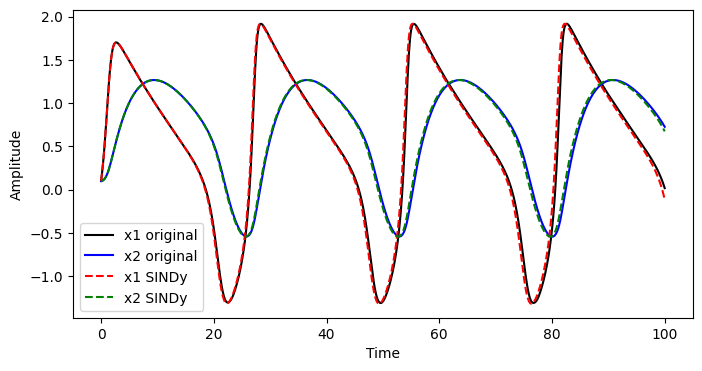

In [4]:
x0 = X[0]

X_sim = model.simulate(x0, t) # Simulate the system

plt.figure(figsize=(8,4))
plt.plot(t, X[:,0], 'k', label='x1 original')
plt.plot(t, X[:,1], 'b', label='x2 original')
plt.plot(t, X_sim[:,0], 'r--', label='x1 SINDy')
plt.plot(t, X_sim[:,1], 'g--', label='x2 SINDy')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Problem 2: Neural Network

The SVM classification problem from P3 is chosen:<br>
Based on a labelled data set from stress-strain measurements, a model is trained that finds which material could the unlabelled data belong to.<br>

First I recreate the SVM algorithm to be able to compare with the ANN

SVM Accuracy on validation set: 96.50%


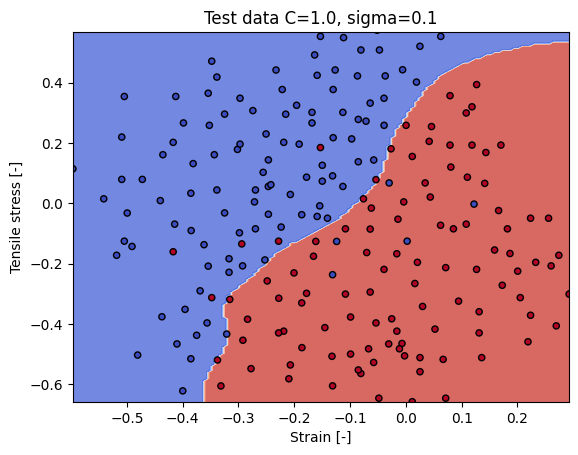

In [90]:
from sklearn import svm, metrics

data = loadmat(folder + "DataSet3.mat")

X = data['X']
y = data['y'].ravel()
Xval = data['Xval']
yval = data['yval'].ravel()

C = 1.0
sigma = 0.1
gamma = 1 / (2 * sigma ** 2)  # here the rbf is parametrized by gamma

model = svm.SVC(C=C, kernel='rbf', gamma=gamma)
clf_svm = model.fit(X, y.ravel())

svm_pred = model.predict(Xval)
svm_acc = metrics.accuracy_score(yval, svm_pred)

print(f"SVM Accuracy on validation set: {svm_acc * 100:.2f}%")

# plot adapted from https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python

def make_meshgrid(x, y, h=0.007):
    # h controls boundary line smoothness
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = f'Test data C={C}, sigma={sigma}'
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_svm, xx, yy, cmap=plt.cm.coolwarm_r, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm_r, s=20, edgecolors='k')
ax.set_ylabel('Tensile stress [-]')
ax.set_xlabel('Strain [-]')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title(title)
plt.show()


![title](SVM_matlab.png)


Above code successfully reproduced the MATLAB results (see boundary plots).

In [91]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)       # fit on training data
Xval_scaled = scaler.transform(Xval)     # transform validation data

training: sgd, constant learning-rate
Neural Network Accuracy on validation set: 93.00%
Training set score: 0.924171
Training set loss: 0.227788
training: sgd, constant with momentum
Neural Network Accuracy on validation set: 93.50%
Training set score: 0.924171
Training set loss: 0.228764
training: adam
Neural Network Accuracy on validation set: 93.00%
Training set score: 0.919431
Training set loss: 0.257453
training: sgd, constant learning-rate
Neural Network Accuracy on validation set: 93.50%
Training set score: 0.928910
Training set loss: 0.233123
training: sgd, constant with momentum
Neural Network Accuracy on validation set: 93.50%
Training set score: 0.928910
Training set loss: 0.232783
training: adam
Neural Network Accuracy on validation set: 94.00%
Training set score: 0.928910
Training set loss: 0.244711
training: sgd, constant learning-rate
Neural Network Accuracy on validation set: 93.00%
Training set score: 0.924171
Training set loss: 0.224093
training: sgd, constant with mo

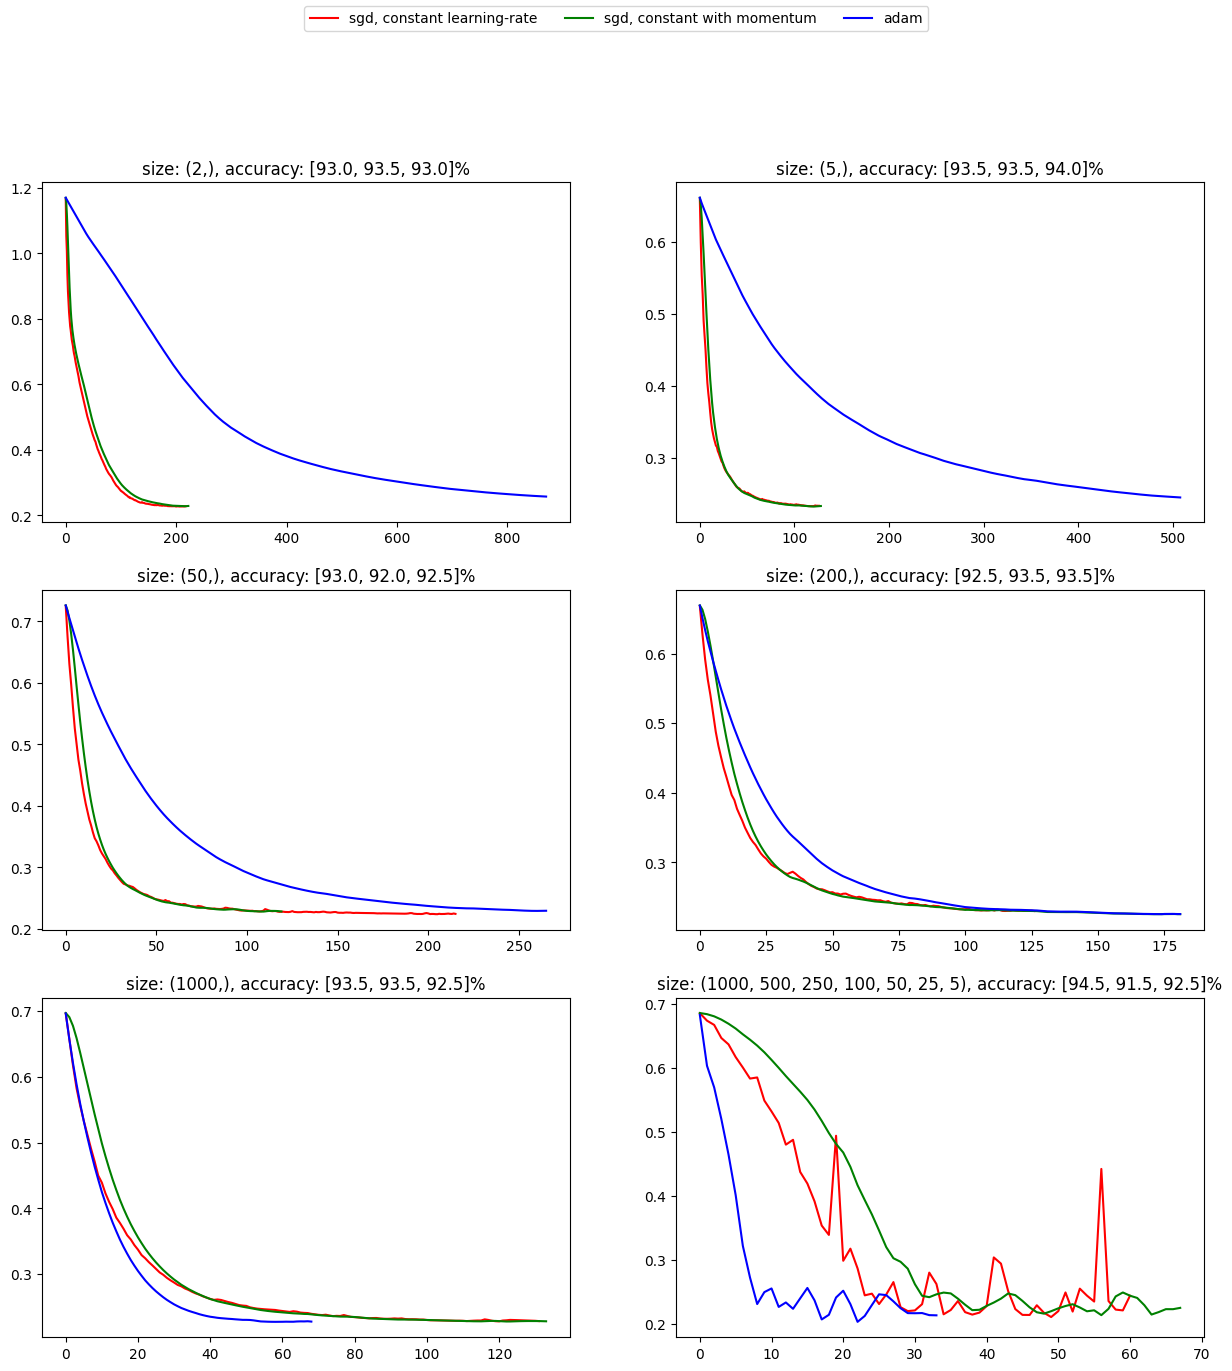

In [94]:
# testing different solvers and learning rate schedules
# adapted from https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.1,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.01,
    },
    {"solver": "adam",
     "learning_rate_init": 0.001},
]

labels = [
    "sgd, constant learning-rate",
    "sgd, constant with momentum",
    "adam",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    # {"c": "red", "linestyle": "--"},
    # {"c": "green", "linestyle": "--"},
    # {"c": "blue", "linestyle": "--"},
    # {"c": "black", "linestyle": "-"},
]

max_iter = 1000

def plot_on_hidden_size(X, y, X_val, ax, hidden_layer_sizes):
    mlps = []
    accuracies = []
    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, **param)
    
        mlp.fit(X, y)
    
        mlps.append(mlp)
        
        nn_pred = mlp.predict(X_val)
        nn_acc = metrics.accuracy_score(yval, nn_pred)
        accuracies.append(nn_acc * 100)
        print(f"Neural Network Accuracy on validation set: {nn_acc * 100:.2f}%")
        
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)
        ax.set_title(f'size: {hidden_layer_sizes}, accuracy: {accuracies}%')

fig, axes = plt.subplots(3,2,figsize=(15, 15))

for ax, size in zip(axes.ravel(), [(2,), (5,), (50,), (200,), (1000,), (1000,500,250,100,50,25,5)]):
    plot_on_hidden_size(X_scaled, y, Xval_scaled, ax, hidden_layer_sizes=size)


fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

## Conclusion on the parameter study:

Not a lot of difference can be observed between solvers and learning rate schedules in terms of accuracy. The network size seems to be the most important factor; one hidden layer is enough, adding complexity only improves the result marginally. Depending on the solver, at least 3-5 neurons are necessary in the hidden layer. Adding more complexity (more neurons & layers) just makes the solvers converge faster, and by creating more complex decision boundary, accuracy may marginally improve.

Iteration 1, loss = 0.73200368
Iteration 2, loss = 0.60616780
Iteration 3, loss = 0.51978027
Iteration 4, loss = 0.43356596
Iteration 5, loss = 0.34445584
Iteration 6, loss = 0.29769115
Iteration 7, loss = 0.25591447
Iteration 8, loss = 0.22787536
Iteration 9, loss = 0.23505227
Iteration 10, loss = 0.24621850
Iteration 11, loss = 0.25254088
Iteration 12, loss = 0.25337702
Iteration 13, loss = 0.24703684
Iteration 14, loss = 0.24517249
Iteration 15, loss = 0.25003567
Iteration 16, loss = 0.25086417
Iteration 17, loss = 0.25676785
Iteration 18, loss = 0.24039645
Iteration 19, loss = 0.22630976
Iteration 20, loss = 0.23656358
Iteration 21, loss = 0.24472494
Iteration 22, loss = 0.23461232
Iteration 23, loss = 0.22738043
Iteration 24, loss = 0.22558123
Iteration 25, loss = 0.21373720
Iteration 26, loss = 0.20049465
Iteration 27, loss = 0.20106824
Iteration 28, loss = 0.19861615
Iteration 29, loss = 0.19545038
Iteration 30, loss = 0.19429747
Iteration 31, loss = 0.19367932
Iteration 32, los

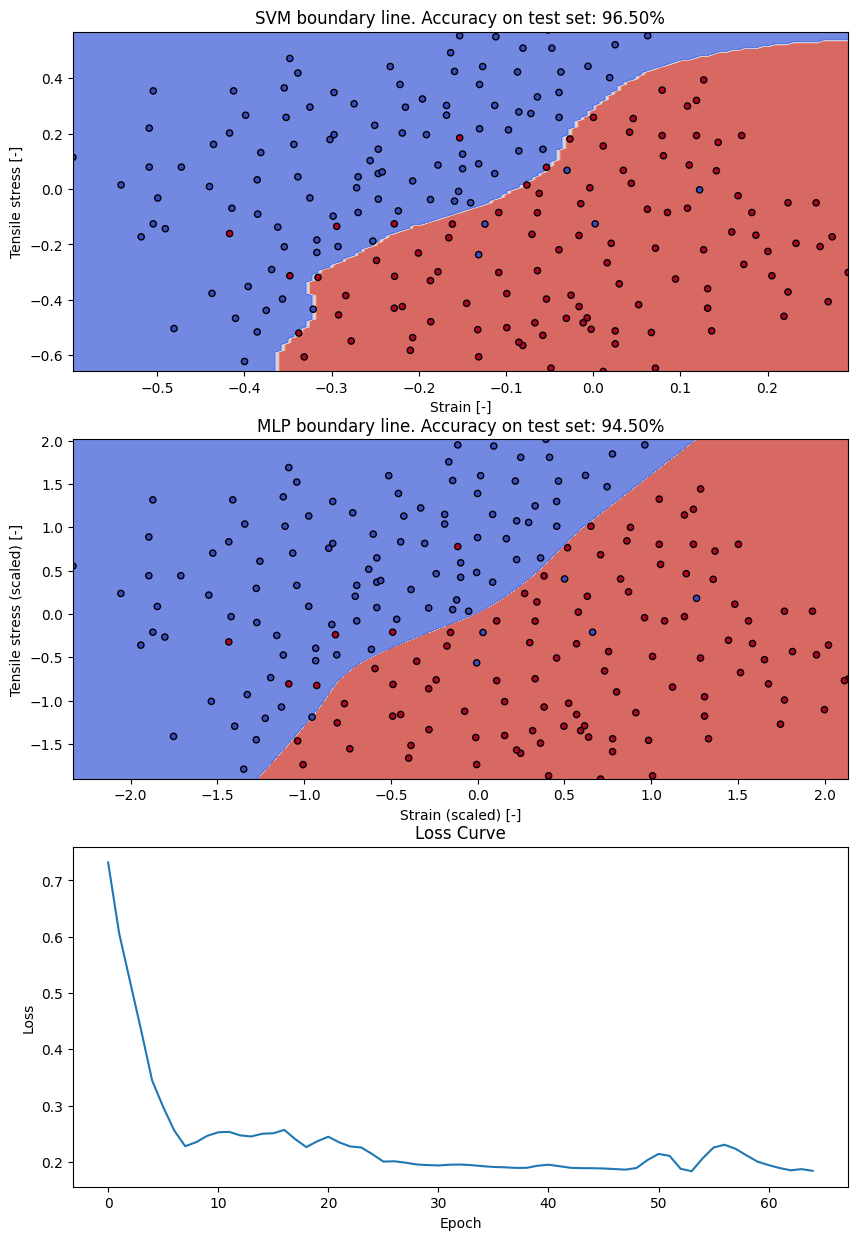

In [105]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 100, 10),
                    solver='adam',
                    learning_rate='constant',
                    learning_rate_init=0.001,
                    max_iter=1000,
                    random_state=0,
                    verbose=True)

clf_mlp = mlp.fit(X_scaled, y)

nn_pred = mlp.predict(Xval_scaled)
nn_acc = metrics.accuracy_score(yval, nn_pred)

fig, ax = plt.subplots(3,1, figsize=(10, 15))

title = f'SVM boundary line. Accuracy on test set: {svm_acc * 100:.2f}%'

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax[0], clf_svm, xx, yy, cmap=plt.cm.coolwarm_r, alpha=0.8)
ax[0].scatter(X0, X1, c=y, cmap=plt.cm.coolwarm_r, s=20, edgecolors='k')
ax[0].set_ylabel('Tensile stress [-]')
ax[0].set_xlabel('Strain [-]')
ax[0].set_xlim(xx.min(), xx.max())
ax[0].set_ylim(yy.min(), yy.max())
ax[0].set_title(title)

title = f'MLP boundary line. Accuracy on test set: {nn_acc * 100:.2f}%'

X0, X1 = X_scaled[:, 0], X_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax[1], clf_mlp, xx, yy, cmap=plt.cm.coolwarm_r, alpha=0.8)
ax[1].scatter(X0, X1, c=y, cmap=plt.cm.coolwarm_r, s=20, edgecolors='k')
ax[1].set_ylabel('Tensile stress (scaled) [-]')
ax[1].set_xlabel('Strain (scaled) [-]')
ax[1].set_xlim(xx.min(), xx.max())
ax[1].set_ylim(yy.min(), yy.max())
ax[1].set_title(title)

ax[2].plot(mlp.loss_curve_)
ax[2].set_title(f'Loss Curve')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')

plt.show()

